In [2]:
from music21 import *
from itertools import permutations

In [3]:
carter = converter.parse('carter_gra_mxl.mxl')

# Helper Functions

### - Normal Form

In [4]:
def perm_list(pitch_list, rotation_amount=1):
    """Rotates a list by rotation_amount"""
    return pitch_list[rotation_amount:] + pitch_list[:rotation_amount]

In [5]:
def check_compactness(pitch_classes, index = -1):
    """Checks distance between first and last notes"""
    return (pitch_classes[index] - pitch_classes[0]) % 12

In [6]:
def check_equal(list1, list2, index):
    """Checks equality if there is a tie for the best intervals between pitches when finding the normal form"""
    if index == -len(list1): # if the lists have equal pitches classes all the way down. Take the one with the lowest starting pitch class
        if list1[0] < list2[0]:
            return list1
        return list2
    if check_compactness(list1, index) == check_compactness(list2, index):
        return check_equal(list1, list2, index-1)
    elif check_compactness(list1, index) < check_compactness(list2, index):
        return list1
    return list2

In [7]:
def most_compact(pitches):
    best_interval, best_pitches = check_compactness(pitches), pitches
    for i in range(len(pitches)):
        rotation = perm_list(pitches, i)
        compactness = check_compactness(rotation)
        if compactness < best_interval:
            best_interval = compactness
            best_pitches = rotation
        if compactness == best_interval:
            best_pitches = check_equal(best_pitches, rotation, index=-2)
    return best_pitches

In [8]:
def reduce_to_normal_form(pitch_list):
    """
    Given a list of musci21 pitch objects, reduces them to their normal form as a 
    list of integers.
    """
    pitch_classes = sorted(list(set(x.pitchClass for x in pitch_list)))
    normal_form = most_compact(pitch_classes)
    return normal_form


In [9]:
# Tests for normal form
def test_normal_form():
    """Runs test cases for the reduction to normal form"""
    P = pitch.Pitch
    pc_ex = [P('C4'), P('C#4'), P('C3'), P('B3')]
    pc1 = [P('Ab4'), P('D4'),P('Eb5'), P('A4')]
    pc2 = [P('B5'), P('G4'), P('D5'), P('Eb'), P('D6')]
    assert reduce_to_normal_form(pc1) == [2,3,8,9]
    assert reduce_to_normal_form(pc_ex) == [11,0,1]
    assert reduce_to_normal_form(pc2) == [11,2,3,7]
    pass
test_normal_form()

### - Prime Form


In [10]:
def transpose_normal(pitch_classes):
    """Given a list of pitch classes in normal form, transposes them to start on C."""
    return [(x+12 - pitch_classes[0])%12 for x in pitch_classes]


In [11]:
def invert_transpose(pitch_classes):
    """Given a list of pitch classes in normal form, transposes them to start on C, then inverts 
    them, then put the inverted form into increasing order."""
    transposed = [(x+12 - pitch_classes[0])%12 for x in pitch_classes]
    inverted = [(-x)%12 for x in transposed]
    increasing = perm_list(sorted(inverted), 1)
    return increasing, transposed

In [12]:
lis = [0,3,4,8]
invert_transpose([0,3,4,8])

([4, 8, 9, 0], [0, 3, 4, 8])

In [13]:
def reduce_to_prime_form(pitch_list, stringify = False):
    """reduces a pitch list to prime form. If stringify = True, then returns the answer as a string. """
    
    inverted, transposed_normal  = invert_transpose(pitch_list)
    best_inverted = most_compact(inverted)
    if check_compactness(best_inverted,) == check_compactness(transposed_normal):
        anslist = check_equal(best_inverted, transposed_normal, index=-2)
    elif check_compactness(best_inverted,) < check_compactness(transposed_normal):
        anslist = best_inverted
    elif check_compactness(best_inverted,) > check_compactness(transposed_normal):
        anslist =  transposed_normal
    transpose2 = transpose_normal(anslist)
    if not stringify:
        return transpose2
    prime_form = ''
    for x in transpose2:
        if x ==10:
            x = 'T'
        elif x == 11:
            x = 'E'
        prime_form = prime_form + str(x)
    return prime_form

    

In [14]:
def test_prime_form():
    """Tests the function reduce_to_prime_form"""
    assert reduce_to_prime_form([11,2,3,7], stringify=True) == '0148'
    assert reduce_to_prime_form([11,2,3,7]) == [0,1,4,8]
    pass


In [15]:
#TODO: add more test cases
test_prime_form()

### - Interval Vectors

In [16]:
def get_interval_vector(pitch_list, zero = False):
    """Given a list of pitches, returns the interval vector between all of the pitches. 
    If zero = true, returns the interval vector that includes 0.
    """
    intervals = {}
    for i in range(len(pitch_list)):
        for j in range(len(pitch_list)-i):
            diff = pitch_list[j+i]-pitch_list[i]
            if diff >6:
                diff = 12-diff
            if diff in intervals:
                intervals[diff] +=1
            else:
                intervals[diff] = 1
    interval_vector = []
    for i in range(7):
        if i in intervals:
            interval_vector.append(intervals[i])
        else:
            interval_vector.append(0)
    if zero:
        return interval_vector
    return interval_vector[1:]

In [17]:
P = pitch.Pitch
def test_interval_vector():
    a = reduce_to_prime_form([11,2,3,7], stringify=False)
    g_half_dim = [P('G4'), P('Bb4'), P('Db5'), P('F5') ]
    G_normal = reduce_to_normal_form(g_half_dim)
    G_prime = reduce_to_prime_form(G_normal)
    assert get_interval_vector(G_prime) == [0,1,2,1,1,1]
    assert get_interval_vector(a) == [1,0,1,3,1,0]
test_interval_vector()

In [18]:
def pitch_to_int_vec(pitch_list):
    """Combines the whole normal -> prime -> interval vector pathway. Takes in a pitch list and returns its interval vector."""
    return get_interval_vector(reduce_to_prime_form(reduce_to_normal_form(pitch_list)))

In [19]:
def test_ptiv():
    g_half_dim = [P('G4'), P('Bb4'), P('Db5'), P('F5') ]
    assert pitch_to_int_vec(g_half_dim) == [0,1,2,1,1,1]
test_ptiv()

### Windowing Functions

In [20]:
def check_window(measures):
    """Given a window in a piece, check it for 4-Z29 or 4-Z15. If we find it in the window, returns the measure numbers 
    that are being evalutated and the pitch_set that was found as the Z-relation. 
    
    This is a factorial algorithm if we use all the notes!
    TODO: MAKE FASTER? Do we need to check every permutation? No we do not? remove duplicate notes first? Probably should add some 
    logic that takes into account ordering or something. More work to be done. """
    notes = list(set(pitch.Pitch(n.name) for n in measures.flatten().getElementsByClass(note.Note)))
    z_relations = []
    seen = []
    for n in permutations(notes, r=4):
        if pitch_to_int_vec(n) == [1,1,1,1,1,1]: # we have found a z-relation
         # but we are checking every permutation. There are going to be like 1000 out of order duplicates, we need to get rid of these
            pitches = set(x.pitchClass for x in n)
            if pitches in seen:
                continue
            else:
                if n in z_relations:
                    continue
                z_relations.append(n)
                seen.append(pitches)
    return z_relations

In [21]:
check_window(carter.measures(0,3),)

[(<music21.pitch.Pitch G#>,
  <music21.pitch.Pitch F>,
  <music21.pitch.Pitch E>,
  <music21.pitch.Pitch B->)]

# Main Function

In [22]:
def find_Z_relation(sc, window):
    """Given a score object and a window in numer of measures, identifies and labels where Z relations occur in the piece. 
    Returns a dictionary that maps windowed measure numbers to Z-relations."""
    total_measures = len(sc.getElementsByClass(stream.Measure)) # TODO: FIX THIS idk why there are no measures rn
    total_measures = 20 # just for now, take out later
    shift_len = int(window/2)
    cur_measure = 0
    Z_rel_dict = {}
    while cur_measure < total_measures:
        checked = check_window(sc.measures(cur_measure, cur_measure+window))
        if len(checked) !=0:
            Z_rel_dict[(cur_measure, cur_measure+window)] = checked
        cur_measure += shift_len
    return Z_rel_dict
        


In [23]:
find_Z_relation(carter, 2)
# print('test')

{(0,
  2): [(<music21.pitch.Pitch B->,
   <music21.pitch.Pitch E>,
   <music21.pitch.Pitch A->,
   <music21.pitch.Pitch F>)],
 (1,
  3): [(<music21.pitch.Pitch G#>,
   <music21.pitch.Pitch F>,
   <music21.pitch.Pitch E>,
   <music21.pitch.Pitch B->)],
 (2,
  4): [(<music21.pitch.Pitch G#>,
   <music21.pitch.Pitch F>,
   <music21.pitch.Pitch E>,
   <music21.pitch.Pitch B->)],
 (3,
  5): [(<music21.pitch.Pitch G#>,
   <music21.pitch.Pitch F>,
   <music21.pitch.Pitch E>,
   <music21.pitch.Pitch B->), (<music21.pitch.Pitch C>,
   <music21.pitch.Pitch E>,
   <music21.pitch.Pitch A>,
   <music21.pitch.Pitch B->)],
 (4,
  6): [(<music21.pitch.Pitch B>,
   <music21.pitch.Pitch C>,
   <music21.pitch.Pitch F>,
   <music21.pitch.Pitch A>), (<music21.pitch.Pitch B>,
   <music21.pitch.Pitch A->,
   <music21.pitch.Pitch E>,
   <music21.pitch.Pitch B->), (<music21.pitch.Pitch C>,
   <music21.pitch.Pitch E>,
   <music21.pitch.Pitch A>,
   <music21.pitch.Pitch B->), (<music21.pitch.Pitch A->,
   <music

In [31]:
for i in carter:
    print(i)

<music21.text.TextBox 'Elliott Ca...'>
<music21.stream.Part BaccidentalFlat Clarinet>
<music21.layout.ScoreLayout>


In [28]:
pitch.Pitch.__repr__ = pitch.Pitch.__str__
bach = corpus.parse('bwv253')
find_Z_relation(bach, 3)
# print('test')


{(0, 3): [(D, B, C#, G),
  (D, C#, G#, E),
  (D, G#, E, G),
  (D, G#, A, F#),
  (B, C#, G#, G),
  (C#, A, G, F#)],
 (1, 4): [(D, B, C#, G),
  (D, C#, G#, E),
  (D, G#, E, G),
  (D, G#, A, F#),
  (B, C#, G#, G),
  (C#, A, G, F#)],
 (2, 5): [(D, B, C#, G),
  (D, C#, G#, E),
  (D, G#, E, G),
  (D, G#, A, F#),
  (B, C#, G#, G),
  (C#, G, A, F#)],
 (3, 6): [(E#, D, D#, A),
  (E#, B, C#, E),
  (E#, B, D#, F#),
  (E#, B, A, F#),
  (E#, G#, D#, A),
  (D, B, D#, A),
  (D, G#, C#, E),
  (D, G#, D#, F#),
  (D, G#, A, F#),
  (B, G#, D#, A),
  (C#, D#, E, A)],
 (4, 7): [(E#, D, D#, A),
  (E#, B, C#, E),
  (E#, B, D#, F#),
  (E#, B, A, F#),
  (E#, G#, D#, A),
  (D, B, D#, A),
  (D, C#, G#, E),
  (D, G#, D#, F#),
  (D, G#, A, F#),
  (B, G#, D#, A),
  (C#, D#, E, A)],
 (5, 8): [(E#, D, D#, A),
  (E#, G#, D#, A),
  (E#, B, C#, E),
  (E#, B, D#, F#),
  (E#, B, A, F#),
  (D, G#, C#, E),
  (D, G#, D#, F#),
  (D, G#, A, F#),
  (D, B, D#, A),
  (G#, B, D#, A),
  (C#, D#, E, A)],
 (6, 9): [(E#, D, D#, A),
  

In [25]:
check_window(bach.measures(0,3))
print('test')

test


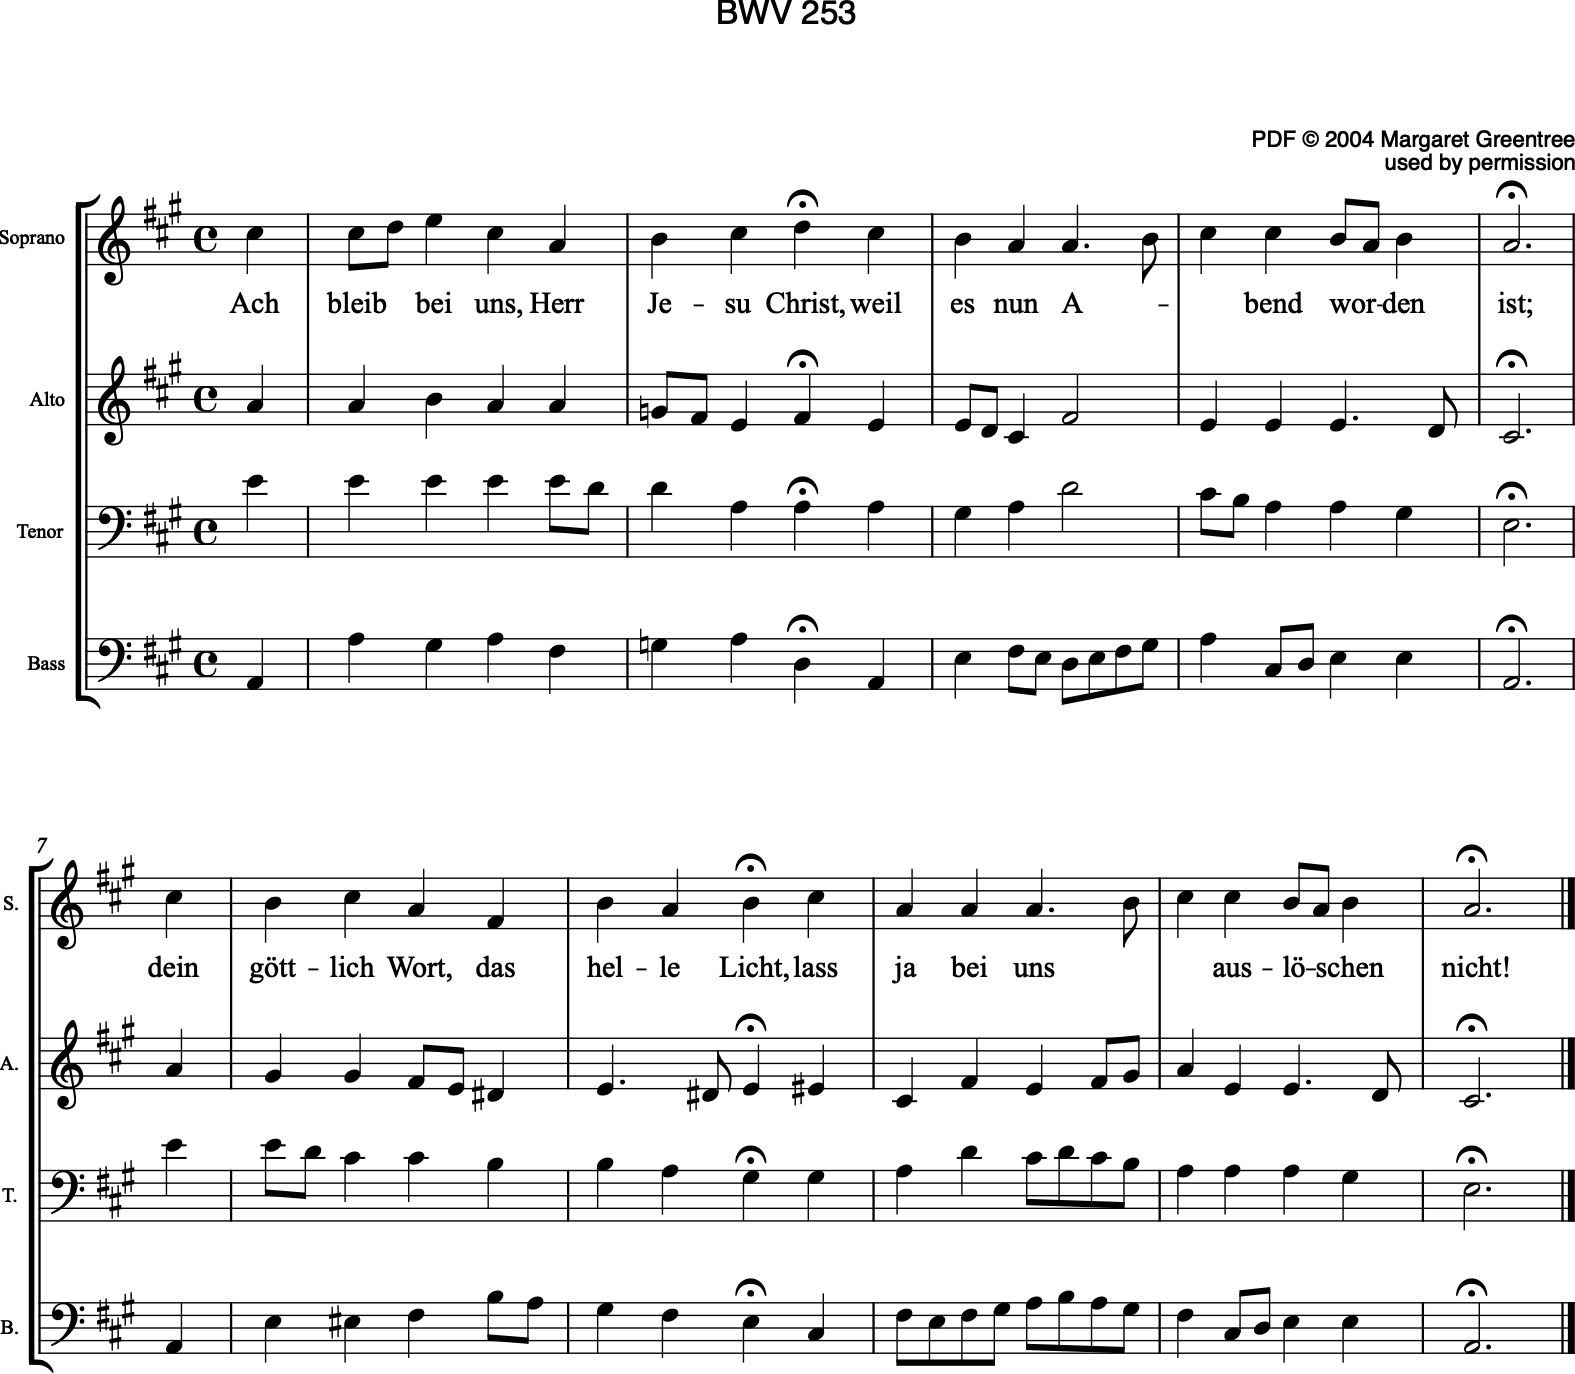

In [32]:
bach.show()